# **Assignment 3 - Part B_2**

## **Using pure pytorch tensor data structure to build a 3 layer neural network with auto differentiation primitives**

In [1]:
##Importing the required libraries
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Initializing weight matrix
data = [[1,2,3], [4,5,6]]
a = torch.tensor(data)
a.shape

torch.Size([2, 3])

In [3]:
##Initializing appropriate values for bias
bias = [[1],[0.5]]
bias = torch.tensor(bias)
print(bias.shape)

torch.Size([2, 1])


In [4]:
##Generating 3d input and calculating y_true value
n = 500
d = 3
x = torch.rand(n, d)
a = a.T

## y1 = x_1^2 + 2 * x_2^2 + 3 * x_3^2 + x_1 + 2 * x_2 + 3 * x_3 + 1
## y2 = 4 * x_1^2 + 5 * x_2^2 + 6 * x_3^2 + 4 * x_1 + 5 * x_2 + 6 * x_3 + 0.5
##Calculating actual output for the data

y_true = torch.matmul(x.float().pow(2), a.float()) + torch.matmul(x.float(), a.float()) + bias.T.float()

##Checking shapes for input, weight, bias and output tensors
print(f'x: {x.shape}, weights: {a.shape}, bias: {bias.shape}, y: {y_true.shape}')

x: torch.Size([500, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([500, 2])


In [5]:
y_true.shape

torch.Size([500, 2])

In [6]:
##Visualizing the data distribution using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_jobs=5).fit_transform(x)
tsne.shape

(500, 2)

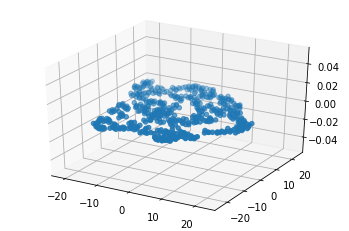

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [8]:
import torch.nn as nn
import math 
##Defining customized loss function
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

##Using auto differentiation to train the model
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

##Checking for the initial loss value
loss = MSE()
model = TorchModel(d, 8)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(121.3935, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
##Function for tsne plot visualization
def tsne_plot(tsne, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne[:, 0], tsne[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(tsne[:, 0], tsne[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

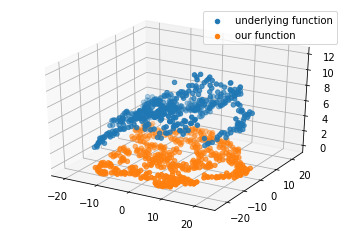

In [10]:
##Visualizing the data distribution using TSNE
tsne_plot(tsne, y_true, model(x_tensor).detach())

In [11]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

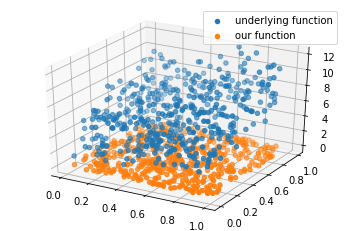

In [12]:
plot_3d(x, y_true, model(x_tensor).detach())

In [13]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

##Checking for initial loss values to make sure its reducing
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(121.3935, grad_fn=<MeanBackward0>)
tensor(86.6682, grad_fn=<MeanBackward0>)


In [14]:
# Now we run the training loop
from typing import Callable

def torch_fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=35)

tensor(86.6682, grad_fn=<MeanBackward0>)
tensor(16.9454, grad_fn=<MeanBackward0>)
tensor(39.4804, grad_fn=<MeanBackward0>)
tensor(87.1198, grad_fn=<MeanBackward0>)
tensor(72.9060, grad_fn=<MeanBackward0>)
tensor(61.9289, grad_fn=<MeanBackward0>)
tensor(53.0350, grad_fn=<MeanBackward0>)
tensor(45.8194, grad_fn=<MeanBackward0>)
tensor(39.9504, grad_fn=<MeanBackward0>)
tensor(35.1029, grad_fn=<MeanBackward0>)
tensor(30.8248, grad_fn=<MeanBackward0>)
tensor(26.3565, grad_fn=<MeanBackward0>)
tensor(20.6284, grad_fn=<MeanBackward0>)
tensor(14.2202, grad_fn=<MeanBackward0>)
tensor(11.4002, grad_fn=<MeanBackward0>)
tensor(10.9071, grad_fn=<MeanBackward0>)
tensor(10.4285, grad_fn=<MeanBackward0>)
tensor(9.9383, grad_fn=<MeanBackward0>)
tensor(9.4294, grad_fn=<MeanBackward0>)
tensor(8.8974, grad_fn=<MeanBackward0>)
tensor(8.3391, grad_fn=<MeanBackward0>)
tensor(7.7529, grad_fn=<MeanBackward0>)
tensor(7.1391, grad_fn=<MeanBackward0>)
tensor(6.5008, grad_fn=<MeanBackward0>)
tensor(5.8503, grad_fn=

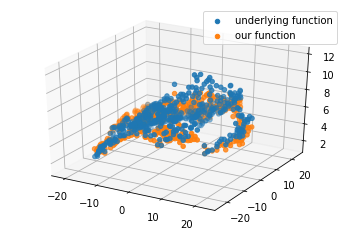

In [15]:
##Visualizing the data distribution using TSNE after training
tsne_plot(tsne, y_true, model(x_tensor).detach())

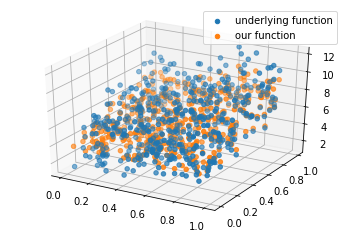

In [16]:
##Visualizing the shape of data after training
plot_3d(x, y_true, model(x_tensor).detach())

We can see how after training, the shape of the data before and after is now similar/overlapping